Name: Enab

Last Name: Muneer

Matricola: 0001057723

#Introduction:

Dementia is a general term for the impaired ability to remember, think, or make decisions that interferes with doing everyday activities. Alzheimer's disease is the most common type of dementia. Though dementia mostly affects older adults, it is not a part of normal aging. Of those at least 65 years of age, there is an estimated 5.0 million adults with dementia in 2014 and projected to be nearly 14 million by 2060.

Bayesian networks are a type of probabilistic graphical models that lie at the intersection between statistics and machine learning. They have been shown to be powerful tools to encode dependence relationships among the variables of a domain under uncertainty. The proposed work addresses the compelling problem of dementia with an application of a Bayesian Network for medical diagnosis and prediction which has its main advantage in its explainability and readability. In particular, some of the causes of dementia are take into consideration in the Network. The idea is taken from the paper "Burge, J., Lane, T., Link, H., Qiu, S., and Clark, V. P. (2009). Discrete dynamic Bayesian network analysis of fMRI data. Hum. Brain Mapp. 30, 122–137. doi:10.1002/hbm.20490". We have taken advantage of Bayesian networks and how they can be learned automatically from data by means of structure learning algorithms. Also, we see how these networks are used for reasoning by exact or approximate inference algorithms that propagate the given evidence through the graphical structure.

In [159]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing Libraries

In [160]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.sampling import GibbsSampling
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.inference import ApproxInference
import warnings
warnings.filterwarnings("ignore")

In [161]:
class Node():
    def __init__(self, name, card, probabilities: list = None, state_names=None):
        self.name = name
        self.card = card
        self.probabilities = probabilities or [[1/card] for _ in range(card)]
        self.state_names = state_names
    def __str__(self):
        return self.name

# Network

Defining the network structure. The acronyms related to dataset attributes are the followings:

Age: age

Neuronal Atrophy: neuronalAtrophy

Stroke: stroke

Dementia: dementia 

Wheelchair: wheelchair

In [162]:
risk_of_dementia_model = BayesianNetwork(
    [
        ("Age", "Neuronal Atrophy"),
        ("Age", "Stroke"),
        ("Neuronal Atrophy", "Dementia"),
        ("Stroke", "Dementia"),
        ("Stroke", "Wheelchair")
    ]
)

Defining the parameters using CPT

In [163]:
age = "Age"
neuronalAtrophy = "Neuronal Atrophy"
stroke = "Stroke"
dementia = "Dementia"
wheelchair = "Wheelchair"

data = [
    (age, 2, [
        [.70],
        [.30],
    ], ['ABOVE_65', 'BELOW_65']),
    (neuronalAtrophy, 2, [
         [.80, .95],
         [0.20, .05],
    ], ['YES', 'NO']),
    (stroke, 2, [
        [.85, .99],
        [.15, .01 ],
    ], ['YES', 'NO']),
    (dementia, 2, [
        [.95, .40, .45, .15],
        [.05, .60, .55, .85],
    ], ['YES', 'NO']),
    (wheelchair, 2, [
        [.70, .10],
        [.30, .90],
    ], ['YES', 'NO']),
]
NODES = {name: Node(name, card, probabilities, state_names) for (name, card, probabilities, state_names) in data}

The Possiblle Values of the Variables are:

In [164]:
# Age
ABOVE_65, BELOW_65 = range(2)

#Neuronal Atrophy, Stroke, Dementia, Wheelchair
YES, NO = range(2)

The CPDs and associating the CPDs with the network structure.

In [165]:
cpds = [
    TabularCPD(
            NODES[node].name,
            NODES[node].card,
            NODES[node].probabilities,
            evidence=risk_of_dementia_model.get_parents(NODES[node].name),
            evidence_card=[NODES[evidence].card for evidence in risk_of_dementia_model.get_parents(NODES[node].name)],
            state_names={NODES[_].name: NODES[_].state_names for _ in [NODES[node].name] + risk_of_dementia_model.get_parents(NODES[node].name)}
        )
        for node in risk_of_dementia_model.nodes()
]
risk_of_dementia_model.add_cpds(*cpds)

checks for the model structure and the associated CPD and returns True if everything is correct otherwise throws an exception.

In [166]:
if risk_of_dementia_model.check_model():
    print("Everything is ok.")

Everything is ok.


In [167]:
#check cpds
for cpds in risk_of_dementia_model.get_cpds():
    print(f'CPT of {cpds.variable} ==>')
    print(cpds, '\n')

CPT of Age ==>
+---------------+-----+
| Age(ABOVE_65) | 0.7 |
+---------------+-----+
| Age(BELOW_65) | 0.3 |
+---------------+-----+ 

CPT of Neuronal Atrophy ==>
+-----------------------+---------------+---------------+
| Age                   | Age(ABOVE_65) | Age(BELOW_65) |
+-----------------------+---------------+---------------+
| Neuronal Atrophy(YES) | 0.8           | 0.95          |
+-----------------------+---------------+---------------+
| Neuronal Atrophy(NO)  | 0.2           | 0.05          |
+-----------------------+---------------+---------------+ 

CPT of Stroke ==>
+-------------+---------------+---------------+
| Age         | Age(ABOVE_65) | Age(BELOW_65) |
+-------------+---------------+---------------+
| Stroke(YES) | 0.85          | 0.99          |
+-------------+---------------+---------------+
| Stroke(NO)  | 0.15          | 0.01          |
+-------------+---------------+---------------+ 

CPT of Dementia ==>
+------------------+-----+----------------------+
|

### Analyzing the network.

Following are the various functions applied on the network:

Viewing nodes of the model.

In [168]:
risk_of_dementia_model.nodes()

NodeView(('Age', 'Neuronal Atrophy', 'Stroke', 'Dementia', 'Wheelchair'))

Viewing edges of the model.

In [169]:
risk_of_dementia_model.edges()

OutEdgeView([('Age', 'Neuronal Atrophy'), ('Age', 'Stroke'), ('Neuronal Atrophy', 'Dementia'), ('Stroke', 'Dementia'), ('Stroke', 'Wheelchair')])

Checking independcies of a node(Dementia,stroke). It can be clearly seen that Dementia doesn't directly depend if the person is using Wheelchair or on the persons age, given their influence on other factors such as Neuronal Antrophy and stroke.

Similarly, stroke doesn't directly depend on Neuronal Antrophy given the age.

In [170]:
risk_of_dementia_model.local_independencies([dementia,stroke])

(Dementia ⟂ Wheelchair, Age | Neuronal Atrophy, Stroke)
(Stroke ⟂ Neuronal Atrophy | Age)

Listing all Independencies


In [171]:
risk_of_dementia_model.get_independencies()

(Dementia ⟂ Wheelchair | Stroke)
(Dementia ⟂ Wheelchair, Age | Neuronal Atrophy, Stroke)
(Dementia ⟂ Wheelchair | Stroke, Age)
(Dementia ⟂ Age | Neuronal Atrophy, Stroke, Wheelchair)
(Dementia ⟂ Wheelchair | Neuronal Atrophy, Stroke, Age)
(Age ⟂ Wheelchair | Stroke)
(Age ⟂ Wheelchair | Dementia, Stroke)
(Age ⟂ Dementia, Wheelchair | Neuronal Atrophy, Stroke)
(Age ⟂ Wheelchair | Dementia, Neuronal Atrophy, Stroke)
(Age ⟂ Dementia | Neuronal Atrophy, Stroke, Wheelchair)
(Neuronal Atrophy ⟂ Wheelchair | Stroke)
(Neuronal Atrophy ⟂ Stroke, Wheelchair | Age)
(Neuronal Atrophy ⟂ Wheelchair | Dementia, Stroke)
(Neuronal Atrophy ⟂ Wheelchair | Stroke, Age)
(Neuronal Atrophy ⟂ Stroke | Age, Wheelchair)
(Neuronal Atrophy ⟂ Wheelchair | Dementia, Stroke, Age)
(Stroke ⟂ Neuronal Atrophy | Age)
(Stroke ⟂ Neuronal Atrophy | Age, Wheelchair)
(Wheelchair ⟂ Dementia, Neuronal Atrophy, Age | Stroke)
(Wheelchair ⟂ Neuronal Atrophy | Age)
(Wheelchair ⟂ Neuronal Atrophy, Age | Dementia, Stroke)
(Wheelchair

Graphical View of the Netwrok.

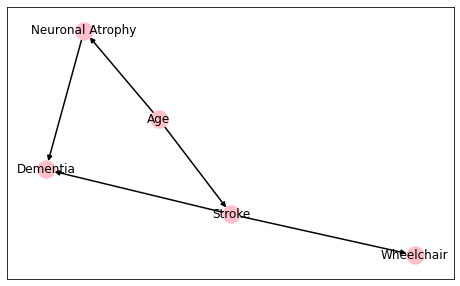

In [191]:
DAG = nx.DiGraph(risk_of_dementia_model.edges())

fig = plt.figure(figsize = (8,5))
pos = nx.spring_layout(DAG) 

nx.draw_networkx_nodes(DAG, pos = pos, node_color = 'pink', node_size = 300)
nx.draw_networkx_labels(DAG, pos = pos)
nx.draw_networkx_edges(DAG, pos = pos, edge_color = 'black', width = 1.5, arrows = True)

plt.show()

Infering the posterior probability

In [173]:
variable_elimination_infer = VariableElimination(risk_of_dementia_model)

We will calculate the probability of having dementia if the age is above 65 or below 65. Does age really affects the chances of having dementia.

In [174]:
for value in [ABOVE_65, BELOW_65]:
     posterior = variable_elimination_infer.query([dementia], evidence={age: value}, show_progress=False)
     print("Probability having dementia with age {} is {}."\
       .format('above 65' if value == ABOVE_65 else 'below 65', posterior.get_value(Dementia=YES)))

Probability having dementia with age above 65 is 0.775.
Probability having dementia with age below 65 is 0.919625.


We will also see the probability of having dementia if a person never has a stroke or neuronal antrophy in their life. It has been seen that these two conditions directly influence dementia. We see there is no difference between ages. 

In [175]:
for value in [ABOVE_65, BELOW_65]:
     posterior = variable_elimination_infer.query([dementia], evidence={age: value, stroke: NO, neuronalAtrophy: NO}, show_progress=False)
     print("Probability having dementia with age {} and no stroke or neuronal antrophy is {}."\
       .format('above 65' if value == ABOVE_65 else 'below 65', posterior.get_value(Dementia=YES)))

Probability having dementia with age above 65 and no stroke or neuronal antrophy is 0.15.
Probability having dementia with age below 65 and no stroke or neuronal antrophy is 0.15.


Since, we know that stroke and neuronal antrphy are the conditions that directly influence dimentia. We will see the probability of having dementia if a person had both a stroke and neuronal antrophy in their life. We see there is no difference between different ages.

In [176]:
for value in [ABOVE_65, BELOW_65]:
     posterior = variable_elimination_infer.query([dementia], evidence={age: value, stroke: YES, neuronalAtrophy: YES}, show_progress=False)
     print("Probability having dementia with age {} having stroke and neuronal antrophy is {}."\
       .format('above 65' if value == ABOVE_65 else 'below 65', posterior.get_value(Dementia=YES)))

Probability having dementia with age above 65 having stroke and neuronal antrophy is 0.95.
Probability having dementia with age below 65 having stroke and neuronal antrophy is 0.95.


We are also able to show if there exist any active trail from nodes, given some observations.

In [177]:
risk_of_dementia_model.active_trail_nodes(stroke, observed='Age')

{'Stroke': {'Dementia', 'Stroke', 'Wheelchair'}}

We can see without any observation stroke has some active trails to other nodes. Let's see what will happen in case we provide its markov blanket as the observation:

In [178]:
stroke_markov_blanket = risk_of_dementia_model.get_markov_blanket(stroke)
risk_of_dementia_model.active_trail_nodes(stroke, observed=stroke_markov_blanket)

{'Stroke': {'Stroke'}}

Given the markov blanket for stroke, there is no more active trail from stroke to the other nodes.

## Sampling and Inferences:


Gibbs Sampling

In [179]:
gibbs_chain = GibbsSampling(risk_of_dementia_model)
inference = BayesianModelSampling(risk_of_dementia_model)

In [180]:
gibbs_sampling_df = gibbs_chain.sample(size=2500, seed=1)
gibbs_sampling_df

  0%|          | 0/2499 [00:00<?, ?it/s]

,Age,Neuronal Atrophy,Stroke,Dementia,Wheelchair
0,1,1,0,0,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2495,0,1,0,0,0
2496,1,0,0,0,0
2497,1,0,0,0,0
2498,1,0,0,0,0


Forward Sampling

In [181]:
forward_sampling_df = inference.forward_sample(size=10000, seed=1, show_progress=False)
forward_sampling_df

,Age,Neuronal Atrophy,Stroke,Dementia,Wheelchair
0,ABOVE_65,YES,YES,YES,YES
1,BELOW_65,NO,YES,NO,YES
2,ABOVE_65,YES,YES,YES,YES
3,ABOVE_65,YES,NO,YES,NO
4,ABOVE_65,NO,NO,NO,YES
...,...,...,...,...,...
9995,ABOVE_65,YES,YES,YES,YES
9996,ABOVE_65,YES,YES,YES,YES
9997,ABOVE_65,YES,YES,YES,NO
9998,ABOVE_65,NO,YES,YES,YES


In [182]:
evidence_dict = {age: ABOVE_65, stroke: YES}
evidence = [State(age, NODES[age].state_names[ABOVE_65]), State(stroke, NODES[stroke].state_names[YES])]

Likelihood weighted sampling

In [183]:
likelihood_weighted_sampling_df = inference.likelihood_weighted_sample(size=10000, seed=1, evidence=evidence, show_progress=False)
likelihood_weighted_sampling_df

,Age,Neuronal Atrophy,Stroke,Dementia,Wheelchair,_weight
0,ABOVE_65,YES,YES,YES,NO,0.595
1,ABOVE_65,YES,YES,YES,YES,0.595
2,ABOVE_65,YES,YES,YES,NO,0.595
3,ABOVE_65,YES,YES,YES,NO,0.595
4,ABOVE_65,YES,YES,YES,NO,0.595
...,...,...,...,...,...,...
9995,ABOVE_65,YES,YES,YES,YES,0.595
9996,ABOVE_65,YES,YES,YES,YES,0.595
9997,ABOVE_65,YES,YES,YES,YES,0.595
9998,ABOVE_65,YES,YES,YES,NO,0.595


Rejection sampling

In [184]:
rejection_sampling_df = inference.rejection_sample(size=10000, evidence=evidence, show_progress=False)
rejection_sampling_df

,Age,Neuronal Atrophy,Stroke,Dementia,Wheelchair
0,ABOVE_65,YES,YES,YES,YES
1,ABOVE_65,YES,YES,YES,YES
2,ABOVE_65,YES,YES,YES,NO
3,ABOVE_65,NO,YES,YES,YES
4,ABOVE_65,YES,YES,YES,YES
...,...,...,...,...,...
9995,ABOVE_65,YES,YES,YES,YES
9996,ABOVE_65,YES,YES,YES,YES
9997,ABOVE_65,YES,YES,YES,YES
9998,ABOVE_65,NO,YES,YES,YES


## Exact/Approximate Inference( Without Evidence)

In [185]:
approximate_inferrence = ApproxInference(risk_of_dementia_model)

Exact Inference

In [186]:
print(variable_elimination_infer.query([dementia], show_progress=False))

+---------------+-----------------+
| Dementia      |   phi(Dementia) |
+===============+=================+
| Dementia(YES) |          0.8184 |
+---------------+-----------------+
| Dementia(NO)  |          0.1816 |
+---------------+-----------------+


Approximate inferrence using sampling methods:

In [187]:
list_of_samples_without_evidence = [
    gibbs_sampling_df,
    forward_sampling_df
]
for samples in list_of_samples_without_evidence:
    print(approximate_inferrence.get_distribution(samples=samples, variables=[dementia]))
    print()

+-------------+-----------------+
| Dementia    |   phi(Dementia) |
+=============+=================+
| Dementia(0) |          0.8188 |
+-------------+-----------------+
| Dementia(1) |          0.1812 |
+-------------+-----------------+

+---------------+-----------------+
| Dementia      |   phi(Dementia) |
+===============+=================+
| Dementia(NO)  |          0.1825 |
+---------------+-----------------+
| Dementia(YES) |          0.8175 |
+---------------+-----------------+



## Exact/Approximate Inference( With Evidence)

Exact Inference

In [188]:
print(variable_elimination_infer.query([dementia], evidence=evidence_dict, show_progress=False))

+---------------+-----------------+
| Dementia      |   phi(Dementia) |
+===============+=================+
| Dementia(YES) |          0.8500 |
+---------------+-----------------+
| Dementia(NO)  |          0.1500 |
+---------------+-----------------+


Approximate inferrence using sampling methods:

In [189]:
list_of_samples_with_evidence = [
    likelihood_weighted_sampling_df,
    rejection_sampling_df
]
for samples in list_of_samples_with_evidence:
    print(approximate_inferrence.get_distribution(samples=samples, variables=[dementia]))
    print()

+---------------+-----------------+
| Dementia      |   phi(Dementia) |
+===============+=================+
| Dementia(NO)  |          0.1492 |
+---------------+-----------------+
| Dementia(YES) |          0.8508 |
+---------------+-----------------+

+---------------+-----------------+
| Dementia      |   phi(Dementia) |
+===============+=================+
| Dementia(NO)  |          0.1440 |
+---------------+-----------------+
| Dementia(YES) |          0.8560 |
+---------------+-----------------+



THANK YOU!